Assumptions 

# Regular user traffic vs. Beacon traffic

Sample beacon config:  

|Sleep|Jitter|Sleep interval|CS Sleep interval
|--|--|--|--|
|300 seconds| 20% | 240-360 seconds|240-300 seconds|

~300 connections in 24 hours.  
*Sleep = time delta  

Users randomly visit/refresh the same web page  

---

Beacon traffic: 300 time deltas, each between 240-360 seconds


User traffic: 300 time deltas, each between 60-600 seconds 

Imports

In [1]:
import math
import pandas as pd
import numpy as np
import warnings
import pymongo
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns

MongoDB Configuration and Data Loading

This script establishes a connection to a MongoDB database and loads data from two collections: 'Packet_Data' and 'Analysis'.


It defines field/column names and sets up configurations for MongoDB connection.


The loaded data is stored in pandas DataFrames: 'http_df' for HTTP data and 'suricata_df' for Suricata alerts.


In [2]:


# MongoDB configuration
mongo_host = 'localhost'
mongo_port = 27017
mongo_db = 'HTTP_Data'
mongo_http_collection = 'Packet_Data'
mongo_suricata_collection = 'Analysis'

# Establish connection to MongoDB
client = pymongo.MongoClient(host=mongo_host, port=mongo_port)
db = client[mongo_db]
http_collection = db[mongo_http_collection]
suricata_collection = db[mongo_suricata_collection]

# Define field/column names
f_timestamp = 'ts'
f_src_ip = 'id.orig_h'
f_dst_ip = 'id.resp_h'
f_dst_host = 'host'
f_dst_port = 'id.resp_p'
f_http_method = 'method'
f_sent_bytes = 'request_body_len'
f_delimiter = '\t'

# Columns to filter, group by, and display
columns_to_filter = [f_timestamp, f_src_ip, f_dst_ip, f_dst_host, f_dst_port, f_http_method, f_sent_bytes]
columns_to_groupby = [f_src_ip, f_dst_ip, f_dst_host, f_dst_port, f_http_method]
columns_to_display = ['Score', 'tsScore', 'dsScore', 'conn_count', f_src_ip, f_dst_ip, f_dst_host, f_http_method, f_dst_port, f_sent_bytes, 'deltas']

# Load data from MongoDB for HTTP data
http_data_cursor = http_collection.find({}, {'_id': 0})
http_df = pd.DataFrame(list(http_data_cursor))

# Load data from MongoDB for Suricata alerts
suricata_data_cursor = suricata_collection.find({}, {'_id': 0})
suricata_df = pd.DataFrame(list(suricata_data_cursor))

Data Preprocessing



Extracts necessary columns from the 'http_df' DataFrame.

Converts the 'f_timestamp' column to datetime format.

Groups the DataFrame by specified columns and aggregates the values into lists.

Creates a new column 'conn_count' which represents the number of connections.

Filters out rows where 'conn_count' is less than or equal to 20.

Calculates time deltas between consecutive timestamps and stores them in a new column 'deltas'.


In [3]:

http_df = http_df.loc[:, columns_to_filter]
http_df[f_timestamp] = pd.to_datetime(http_df[f_timestamp], unit='s')

http_df = http_df.groupby(columns_to_groupby).agg(list).reset_index()

http_df['conn_count'] = http_df[f_timestamp].apply(lambda x: len(x))
http_df = http_df.loc[http_df['conn_count'] > 20]

http_df['deltas'] = http_df[f_timestamp].apply(lambda x: pd.Series(x).diff().dt.seconds.dropna().tolist())


Time Statistics Calculations

Calculate time and data statistics for the HTTP DataFrame.

This code calculates various statistics for the 'deltas' and 'request_body_len' columns of the HTTP DataFrame.
The calculated statistics include percentiles, Bowley's skewness, median absolute deviation from the median, and connection duration.

The calculated statistics are stored in the following columns of the DataFrame:
- tsLow: 20th percentile of 'deltas'
- tsMid: 50th percentile (median) of 'deltas'
- tsHigh: 80th percentile of 'deltas'
- tsBowleyNum: Numerator of Bowley's skewness for 'deltas'
- tsBowleyDen: Denominator of Bowley's skewness for 'deltas'
- tsSkew: Bowley's skewness for 'deltas'
- tsMadm: Median absolute deviation from the median for 'deltas'
- tsConnDiv: Connection duration in seconds divided by 90
- dsLow: 20th percentile of 'request_body_len'
- dsMid: 50th percentile (median) of 'request_body_len'
- dsHigh: 80th percentile of 'request_body_len'
- dsBowleyNum: Numerator of Bowley's skewness for 'request_body_len'
- dsBowleyDen: Denominator of Bowley's skewness for 'request_body_len'
- dsSkew: Bowley's skewness for 'request_body_len'
- dsMadm: Median absolute deviation from the median for 'request_body_len'


In [4]:
http_df['tsLow'] = http_df['deltas'].apply(lambda x: np.percentile(np.array(x), 20))
http_df['tsMid'] = http_df['deltas'].apply(lambda x: np.percentile(np.array(x), 50))
http_df['tsHigh'] = http_df['deltas'].apply(lambda x: np.percentile(np.array(x), 80))
http_df['tsBowleyNum'] = http_df['tsLow'] + http_df['tsHigh'] - 2 * http_df['tsMid']
http_df['tsBowleyDen'] = http_df['tsHigh'] - http_df['tsLow']
http_df['tsSkew'] = http_df[['tsLow', 'tsMid', 'tsHigh', 'tsBowleyNum', 'tsBowleyDen']].apply(
    lambda x: x['tsBowleyNum'] / x['tsBowleyDen'] if x['tsBowleyDen'] != 0 and x['tsMid'] != x['tsLow'] and x['tsMid'] != x['tsHigh'] else 0.0, axis=1
)

http_df['tsMadm'] = http_df['deltas'].apply(lambda x: np.median(np.absolute(np.array(x) - np.median(np.array(x)))))
http_df['tsConnDiv'] = http_df[f_timestamp].apply(lambda x: (x[-1].to_pydatetime() - x[0].to_pydatetime()).seconds / 90)
http_df['dsLow'] = http_df['request_body_len'].apply(lambda x: np.percentile(np.array(x), 20))
http_df['dsMid'] = http_df['request_body_len'].apply(lambda x: np.percentile(np.array(x), 50))
http_df['dsHigh'] = http_df['request_body_len'].apply(lambda x: np.percentile(np.array(x), 80))
http_df['dsBowleyNum'] = http_df['dsLow'] + http_df['dsHigh'] - 2 * http_df['dsMid']
http_df['dsBowleyDen'] = http_df['dsHigh'] - http_df['dsLow']
http_df['dsSkew'] = http_df[['dsLow','dsMid','dsHigh','dsBowleyNum','dsBowleyDen']].apply(
    lambda x: x['dsBowleyNum'] / x['dsBowleyDen'] if x['dsBowleyDen'] != 0 and x['dsMid'] != x['dsLow'] and x['dsMid'] != x['dsHigh'] else 0.0, axis=1
)
http_df['dsMadm'] = http_df['request_body_len'].apply(lambda x: np.median(np.absolute(np.array(x) - np.median(np.array(x)))))


C:\Users\harih\AppData\Local\Temp\ipykernel_4556\2978879417.py:11: UserWarning: Discarding nonzero nanoseconds in conversion.
  http_df['tsConnDiv'] = http_df[f_timestamp].apply(lambda x: (x[-1].to_pydatetime() - x[0].to_pydatetime()).seconds / 90)


Score Calculations

Calculates various scores for HTTP data based on different criteria.
The scores include time delta score, data size score, and overall score.

Time Delta Score Calculation:
- tsSkewScore: Calculates the skew score based on the absolute value of tsSkew.
- tsMadmScore: Calculates the Madm score based on tsMadm. If tsMadm is greater than 30 seconds, the score might be zero.
- tsConnCountScore: Calculates the connection count score based on the ratio of conn_count to tsConnDiv.
- tsScore: Calculates the overall time delta score by averaging tsSkewScore, tsMadmScore, and tsConnCountScore.

Data Size Score Calculation:
- dsSkewScore: Calculates the skew score based on the absolute value of dsSkew.
- dsMadmScore: Calculates the Madm score based on dsMadm. If dsMadm is greater than 128 bytes, the score might be zero.
- dsSmallnessScore: Calculates the smallness score based on the ratio of dsMid to 8192. A higher ratio makes the score more sensitive.
- dsScore: Calculates the overall data size score by averaging dsSkewScore, dsMadmScore, and dsSmallnessScore.

Overall Score Calculation:
- Score: Calculates the overall score by averaging dsScore and tsScore.


In [5]:

# Time delta score calculation
http_df['tsSkewScore'] = 1.0 - abs(http_df['tsSkew'])

# If jitter is greater than 30 seconds, say 90 seconds, MadmScore might be zero
# It depends on how the jitter is implemented.
http_df['tsMadmScore'] = 1.0 - (http_df['tsMadm'] / 30.0)
http_df['tsMadmScore'] = http_df['tsMadmScore'].apply(lambda x: 0 if x < 0 else x)
http_df['tsConnCountScore'] = (http_df['conn_count']) / http_df['tsConnDiv']
http_df['tsConnCountScore'] = http_df['tsConnCountScore'].apply(lambda x: 1.0 if x > 1.0 else x)
http_df['tsScore'] = (((http_df['tsSkewScore'] + http_df['tsMadmScore'] + http_df['tsConnCountScore']) / 3.0) * 1000) / 1000

# Data size score calculation of sent bytes
http_df['dsSkewScore'] = 1.0 - abs(http_df['dsSkew'])

# If data jitter is greater than 128 bytes, say 300 bytes, MadmScore might be zero
# Depends on how the jitter is implemented. 
http_df['dsMadmScore'] = 1.0 - (http_df['dsMadm'] / 128.0)
http_df['dsMadmScore'] = http_df['dsMadmScore'].apply(lambda x: 0 if x < 0 else x)

# Perfect beacons don't send too much data since they are idle and just checking in, 
# division by a high number makes the score insensitive. 
# Making the smallness score more sensitive as it makes more sense. 
http_df['dsSmallnessScore'] = 1.0 - (http_df['dsMid'] / 8192.0)
http_df['dsSmallnessScore'] = http_df['dsSmallnessScore'].apply(lambda x: 0 if x < 0 else x)
http_df['dsScore'] = (((http_df['dsSkewScore'] + http_df['dsMadmScore'] + http_df['dsSmallnessScore']) / 3.0) * 1000) / 1000

# Overall Score calculation
http_df['Score'] = (http_df['dsScore'] + http_df['tsScore']) / 2


Gaussian Mixture Models (GMMs)

Analyzes HTTP data using Gaussian Mixture Model (GMM) for anomaly detection.

Args:

    - http_df (pandas.DataFrame): The HTTP data as a pandas DataFrame.
    
    - columns_to_display (list): List of column names to display in the output.

Returns:

    - pandas.DataFrame: DataFrame containing the anomalies detected by GMM analysis.

In [6]:
from sklearn.mixture import GaussianMixture

# Select features for GMM
features_for_gmm = ['tsScore', 'dsScore', 'conn_count']

# Define independent variables (X_gmm)
X_gmm = http_df[features_for_gmm]

# Initialize Gaussian Mixture model
gmm = GaussianMixture(n_components=3, random_state=50)  # You can adjust the number of components

# Fit the GMM model
gmm.fit(X_gmm)

# Predict the GMM scores
http_df['gmm_score'] = gmm.score_samples(X_gmm)

# Set a threshold for anomalies based on GMM scores
gmm_score_threshold = -10  # You can adjust the threshold based on your data
anomalies_gmm = http_df[http_df['gmm_score'] < gmm_score_threshold]

# Display anomalies from GMM analysis
anomalies_gmm[columns_to_display + ['gmm_score']]


Score   tsScore   dsScore  conn_count        id.orig_h  \
444    0.352329  0.520573  0.184086          33      10.1.15.101   
454    0.341858  0.450719  0.232996          30      10.1.15.101   
2074   0.219807  0.115635  0.323978          33     10.11.15.101   
2976   0.426276  0.635505  0.217046          21     10.12.23.102   
3418   0.558173  0.877778  0.238569          27     10.12.28.101   
3421   0.364592  0.655563  0.073620          21     10.12.28.102   
3428   0.423203  0.707407  0.138999          36     10.12.28.102   
3448   0.464326  0.705051  0.223601          45     10.12.29.101   
3988   1.000000  1.000000  1.000000       25809       10.2.2.101   
4190   0.827782  0.655563  1.000000         234       10.2.4.101   
6437   0.996073  1.000000  0.992147         351      10.4.26.103   
8857   0.830933  0.666667  0.995199         285      10.6.15.107   
9485   0.806754  0.618391  0.995117         312      10.7.16.102   
9509   0.333982  0.503407  0.164557          27      10.7.17.103   
9740   1.000000  1.000000  1.000000       33399      10.7.25.101   
11023  0.648854  1.000000  0.297708         102      10.9.22.101   
11184  0.285083  0.363966  0.206200          21       10.9.3.101   
11396  0.963635  1.000000  0.927271        1044  139.199.184.166   
12647  0.827782  0.655563  1.000000         411   172.16.181.133   
13133  0.883333  0.766667  1.000000         213   172.16.223.131   
13456  0.612926  1.000000  0.225852          45     172.16.3.122   
13532  0.612926  0.988889  0.236962          21     172.16.3.122   
13681  0.677842  0.357149  0.998535         342     172.16.4.205   
13861  0.827782  0.655563  1.000000         249     172.16.95.97   
13955  0.860256  0.720513  1.000000         213    192.168.1.104   
16427  0.827782  0.655563  1.000000         219   192.168.137.85   
16453  0.805571  0.611142  1.000000         243   192.168.137.85   

            id.resp_h                           host method  id.resp_p  \
444     200.75.39.254                  200.75.39.254   POST         80   
454    37.187.195.209                 37.187.195.209   POST        443   
2074    178.63.78.150                  178.63.78.150   POST       8080   
2976    104.236.52.89                  104.236.52.89   POST       8080   
3418   75.177.207.146                 75.177.207.146   POST         80   
3421    104.236.52.89                  104.236.52.89   POST       8080   
3428    189.34.18.252                  189.34.18.252   POST       8080   
3448    189.34.18.252                  189.34.18.252   POST       8080   
3988    192.254.79.71                  192.254.79.71    GET       8080   
4190    50.62.111.116            montanamanshops.com    GET         80   
6437   194.87.101.142           ronjustthetrebho.net   POST         80   
8857   185.15.208.195                   peroptepa.ru   POST         80   
9485     46.254.18.55                tonssuketgo.com   POST         80   
9509    104.236.52.89                  104.236.52.89   POST       8080   
9740     31.44.184.33                   31.44.184.33    GET         80   
11023   144.217.64.68       fritas.cheddarmcmelt.top   POST         80   
11184    62.210.90.75                   62.210.90.75   POST        443   
11396    10.12.25.101                 128.199.64.235   POST         80   
12647   185.6.139.221                    missplus.hu    GET         80   
13133  212.92.187.130                king-jinert.com    GET         80   
13456    50.31.185.52             revee.outbrain.com   POST         80   
13532    64.74.236.18             revee.outbrain.com   POST         80   
13681     31.7.62.214                    31.7.62.214   POST        443   
13861  187.17.111.104                 www.acfmaq.com    GET         80   
13955   216.21.215.30                    koonzie.com    GET         80   
16427   202.152.48.35  www.twentyone-development.com    GET         80   
16453  74.208.173.200            www.bluproducts.com    GET         80   

                                

Overall Score Calculation and Sorting

In [7]:
# Overall Score calculation
http_df['Score'] = (http_df['dsScore'] + http_df['tsScore']) / 2

# Sort DataFrame by 'Score' in descending order
http_df.sort_values(by='Score', ascending=True, inplace=True, ignore_index=True)

# Display top 30 rows with specified columns
http_df[columns_to_display].head(30)


Score   tsScore   dsScore  conn_count        id.orig_h  \
0   0.219807  0.115635  0.323978          33     10.11.15.101   
1   0.285083  0.363966  0.206200          21       10.9.3.101   
2   0.331989  0.268570  0.395408          45     10.11.11.101   
3   0.333982  0.503407  0.164557          27      10.7.17.103   
4   0.341858  0.450719  0.232996          30      10.1.15.101   
5   0.347302  0.343860  0.350745          63      10.6.18.103   
6   0.347617  0.248679  0.446555          21     10.12.20.101   
7   0.352329  0.520573  0.184086          33      10.1.15.101   
8   0.353110  0.153252  0.552968          27     10.12.23.101   
9   0.364592  0.655563  0.073620          21     10.12.28.102   
10  0.365628  0.145284  0.585973          21      10.12.6.101   
11  0.372029  0.174436  0.569622          57      10.2.21.201   
12  0.395971  0.465407  0.326535          81     10.12.23.101   
13  0.402595  0.437834  0.367357          27     172.16.1.101   
14  0.408079  0.220398  0.595760          60     10.20.30.101   
15  0.409848  0.323324  0.496372          33      10.10.5.101   
16  0.423203  0.707407  0.138999          36     10.12.28.102   
17  0.426276  0.635505  0.217046          21     10.12.23.102   
18  0.440265  0.087636  0.792894          21     10.11.21.101   
19  0.441286  0.334138  0.548435          63     10.12.29.101   
20  0.449257  0.466806  0.431708          24      10.6.28.102   
21  0.455530  0.355907  0.555154          21     10.11.11.101   
22  0.457862  0.433832  0.481893          75       10.6.6.104   
23  0.457881  0.333573  0.582190          24      10.8.21.102   
24  0.458486  0.523810  0.393163          27     10.11.21.101   
25  0.458862  0.321085  0.596639          24  192.168.221.134   
26  0.464326  0.705051  0.223601          45     10.12.29.101   
27  0.465068  0.646687  0.283448          30       10.1.2.101   
28  0.465331  0.194071  0.736591          27     172.17.1.101   
29  0.471046  0.344029  0.598063          51       10.8.5.102   

          id.resp_h                      host method  id.resp_p  \
0     178.63.78.150             178.63.78.150   POST       8080   
1      62.210.90.75              62.210.90.75   POST        443   
2    51.254.218.210            51.254.218.210   POST       8080   
3     104.236.52.89             104.236.52.89   POST       8080   
4    37.187.195.209            37.187.195.209   POST        443   
5      84.38.182.41  snnmnkxdhflwgthqismb.com   POST         80   
6      46.101.7.140              46.101.7.140   POST       8080   
7     200.75.39.254             200.75.39.254   POST         80   
8     167.99.105.11             167.99.105.11   POST       8080   
9     104.236.52.89             104.236.52.89   POST       8080   
10  170.238.117.187           170.238.117.187   POST       8082   
11    80.78.253.177            nataranrep.com   POST         80   
12     97.120.3.198              97.120.3.198   POST         80   
13     93.83.161.35              93.83.161.35   POST       7080   
14  203.176.135.102           203.176.135.102   POST       8082   
15     45.62.123.98             beoftmala.com   POST         80   
16    189.34.18.252             189.34.18.252   POST       8080   
17    104.236.52.89             104.236.52.89   POST       8080   
18  222.239.249.166           222.239.249.166   POST        443   
19   82.118.225.196            82.118.225.196   POST       7080   
20   91.201.214.170            tounundhem.com   POST         80   
21  170.238.117.187           170.238.117.187   POST       8082   
22  146.185.243.146          hedttoftsanot.ru   POST         80   
23    217.29.63.222          fortsiretbab.com   POST         80   
24  170.238.117.187           170.238.117.187   POST       8082   
25   173.224.126.40        yvcuoclrigdoh5.com   POST         80   
26    189.34.18.252             189.34.18.252   POST       8080   
27  198.105.244.228                         -      -         80   
28   74.208.125.192            74.208.125.192   

Display Top 30 Rows and Anomalies

In [8]:
# Display top 30 rows with specified columns
http_df[columns_to_display].head(30)

# Display anomalies for scores greater than 0.80
http_df.loc[http_df['Score'] > 0.80, columns_to_display]

Score   tsScore  dsScore  conn_count        id.orig_h  \
288   0.800008  0.600015      1.0          21   192.168.122.34   
289   0.800015  0.600031      1.0          24     10.12.20.102   
290   0.800023  0.600046      1.0          24  192.168.204.151   
291   0.800023  0.600046      1.0          36   172.16.165.165   
292   0.800045  0.600090      1.0          24   172.16.165.133   
...        ...       ...      ...         ...              ...   
1811  1.000000  1.000000      1.0          27   172.16.223.134   
1812  1.000000  1.000000      1.0          36   172.16.223.135   
1813  1.000000  1.000000      1.0          24   172.16.223.135   
1814  1.000000  1.000000      1.0          66   172.16.165.164   
1815  1.000000  1.000000      1.0          36   192.168.56.103   

           id.resp_h                                              host method  \
288    78.46.107.218                             geeksdronesfamily.net    GET   
289    49.51.173.233                                     api2.doter.at    GET   
290    72.52.130.218                                    edulookout.com    GET   
291    37.200.69.143                   stand.trustandprobaterealty.com    GET   
292   177.55.108.130                             camaraguape.mg.gov.br    GET   
...              ...                                               ...    ...   
1811   87.98.146.123  activex.adobe.flash.player.transdisciplinar.info    GET   
1812  166.78.152.216                                 www.undertone.com    GET   
1813   62.149.142.85                                  www.matercom.net    GET   
1814  194.58.103.250                     paytordmbdekmizq.torpacho.com    GET   
1815   79.142.66.239                      report.7931793s793u7my17.com    GET   

      id.resp_p                                   request_body_len  \
288          80  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
289          80  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
290          80  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
291          80  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
292          80  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...         ...                                                ...   
1811         80  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1812         80  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1813         80  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1814         80  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1815         80  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                 deltas  
288   [16.0, 10.0, 2.0, 9.0, 8.0, 86399.0, 86354.0, ...  
289   [86399.0, 5.0, 86398.0, 3.0, 1.0, 7.0, 600.0, ...  
290   [6.0, 9.0, 2.0, 86399.0, 0.0, 0.0, 86399.0, 86...  
291   [86399.0, 6.0, 10.0, 10.0, 0.0, 18.0, 0.0, 0.0...  
292   [0.0, 9.0, 86395.0, 1.0, 7.0, 0.0, 13.0, 86370...  
...                                                 ...  
1811  [0.0, 0.0, 0.0, 0.0, 86399.0, 86399.0, 0.0, 93...  
1812  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1813  [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 86396.0, 2...  
1814  [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...  
1815  [0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 10.0, 10.0, 0.0...  

[1528 rows x 11 columns]

Filtering Suricata Alerts

 Filters Suricata alerts based on a list of destination IP addresses.

    Args:
        dest_ip_list (list): List of destination IP addresses to filter.

    Returns:
        pandas.DataFrame: Filtered Suricata alerts DataFrame with relevant information.


In [9]:
# Define a list of destination IP addresses to filter
dest_ip_list = ['107.181.187.14', '5.199.162.3', '23.74.28.9', '35.198.166.240',
                '193.33.134.7', '31.184.192.202', '5.149.222.125', '185.180.198.24',
                '173.254.231.111', '139.60.161.74', '192.254.79.71', '185.68.93.18',
                '69.16.143.110', '37.59.68.215', '31.44.184.33', '178.74.214.194']

# Filter Suricata alerts for specific destination IP addresses
suricata_alerts_filtered = suricata_df.loc[suricata_df['dest_ip'].isin(dest_ip_list)]

# Display relevant Suricata alerts information
suricata_alerts_filtered[['src_ip', 'dest_ip', 'alert']].apply(
    lambda row: pd.Series({'src_ip': row['src_ip'],
                           'dest_ip': row['dest_ip'],
                           'alert_signature': row['alert']['signature']}), axis=1).drop_duplicates()

src_ip          dest_ip  \
1392         10.17.6.93    139.60.161.74   
1772         10.17.6.93    139.60.161.74   
8151          10.5.26.4      5.199.162.3   
11403        10.2.2.101    192.254.79.71   
11433        10.2.2.101    192.254.79.71   
13811        10.2.2.101    192.254.79.71   
20123        10.2.2.101    192.254.79.71   
62016       10.7.25.101     31.44.184.33   
72576       10.7.25.101     31.44.184.33   
73327       10.7.22.101     31.44.184.33   
73329       10.7.22.101     31.44.184.33   
78256       10.0.90.109     31.44.184.33   
78257       10.0.90.109     31.44.184.33   
78387        10.7.2.102     31.44.184.33   
78467        10.7.2.101     37.59.68.215   
78468        10.7.2.101     37.59.68.215   
78545        10.7.2.101     37.59.68.215   
78546        10.7.2.101     37.59.68.215   
90582      192.168.1.95     185.68.93.18   
125008    10.14.106.192  173.254.231.111   
141941  192.168.204.149   178.74.214.194   
142742   172.16.165.153   31.184.192.202   
142764   172.16.165.153   31.184.192.202   
143818  192.168.204.230   31.184.192.202   
144482  192.168.204.230   31.184.192.202   
150584    192.168.1.109    69.16.143.110   
150585    192.168.1.109    69.16.143.110   
150613    192.168.1.109    69.16.143.110   

                                          alert_signature  
1392             ET MALWARE Cobalt Strike Beacon Observed  
1772    ET HUNTING GENERIC SUSPICIOUS POST to Dotted Q...  
8151    ET MALWARE Cobalt Strike Malleable C2 Profile ...  
11403            ET MALWARE Cobalt Strike Beacon Observed  
11433            ET JA3 Hash - [Abuse.ch] Possible Dridex  
13811   ET HUNTING GENERIC SUSPICIOUS POST to Dotted Q...  
20123   ET ADWARE_PUP Fun Web Products Spyware User-Ag...  
62016            ET MALWARE Cobalt Strike Beacon Observed  
72576   ET HUNTING GENERIC SUSPICIOUS POST to Dotted Q...  
73327   ET HUNTING GENERIC SUSPICIOUS POST to Dotted Q...  
73329            ET MALWARE Cobalt Strike Beacon Observed  
78256   ET HUNTING GENERIC SUSPICIOUS POST to Dotted Q...  
78257            ET MALWARE Cobalt Strike Beacon Observed  
78387            ET MALWARE Cobalt Strike Beacon Observed  
78467       ET MALWARE Suspected Powershell Empire GET M1  
78468   ET MALWARE Possible PowerShell Empire Activity...  
78545      ET MALWARE Suspected Powershell Empire POST M1  
78546           ET POLICY HTTP traffic on port 443 (POST)  
90582   ET HUNTING GENERIC SUSPICIOUS POST to Dotted Q...  
125008             ET INFO HTTP Request to a *.top domain  
141941                     ET MALWARE Win32/Zemot Checkin  
142742              ET MALWARE Poweliks Clickfraud CnC M1  
142764              ET MALWARE Win32/Poweliks GET Request  
143818              ET MALWARE Poweliks Clickfraud CnC M1  
144482              ET MALWARE Win32/Poweliks GET Request  
150584                 ET MALWARE Zbot POST Request to C2  
150585  ET POLICY HTTP Request to .su TLD (Soviet Unio...  
150613                         ET MALWARE Citadel Checkin

Visualization

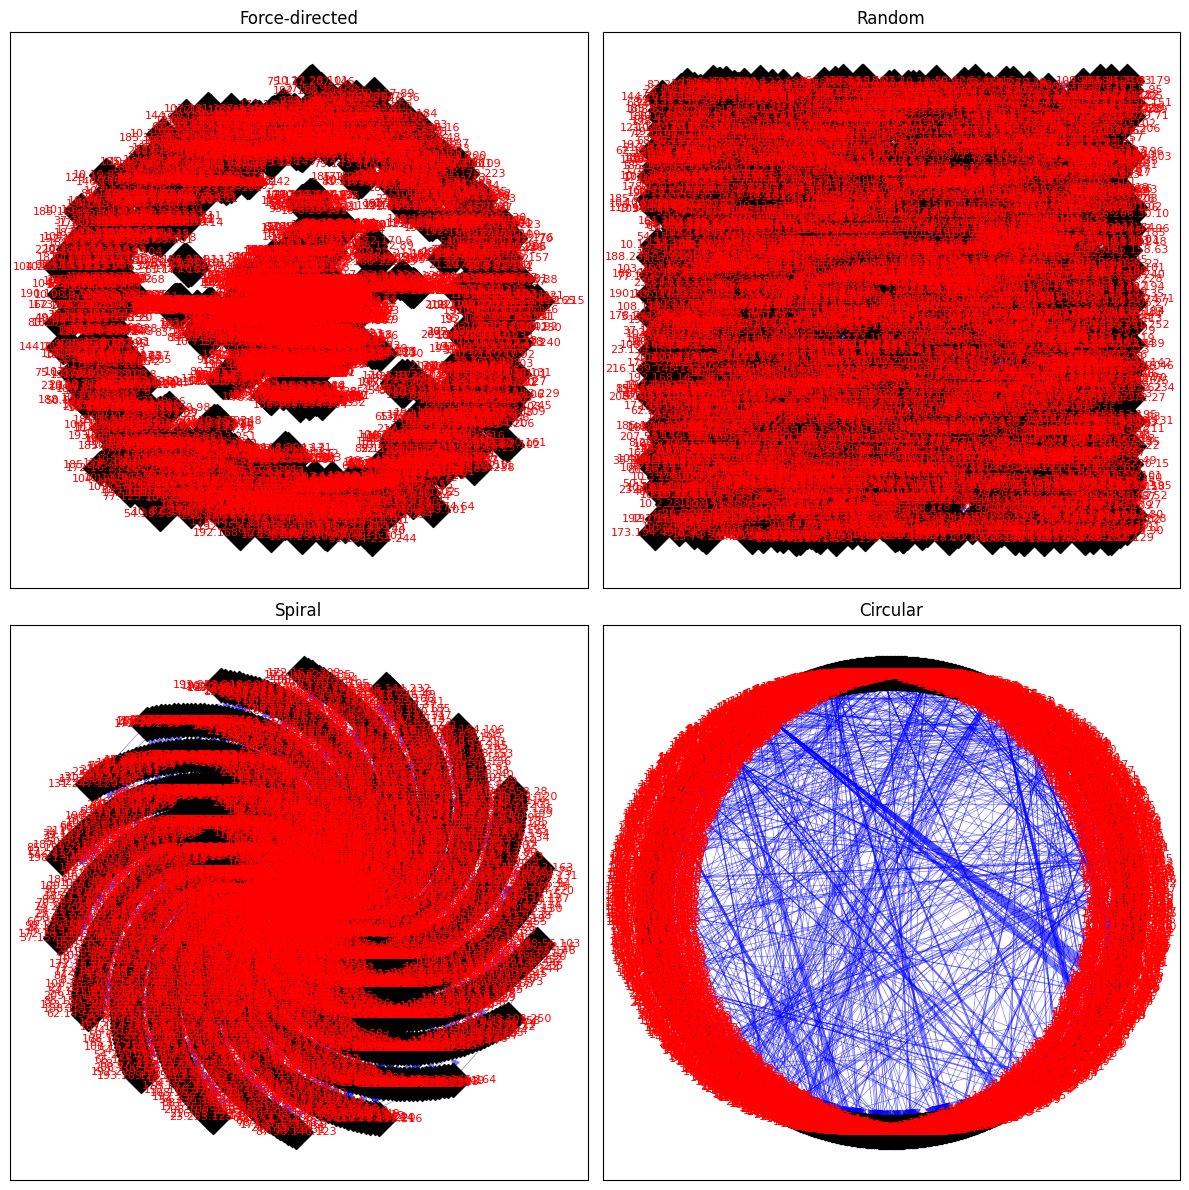

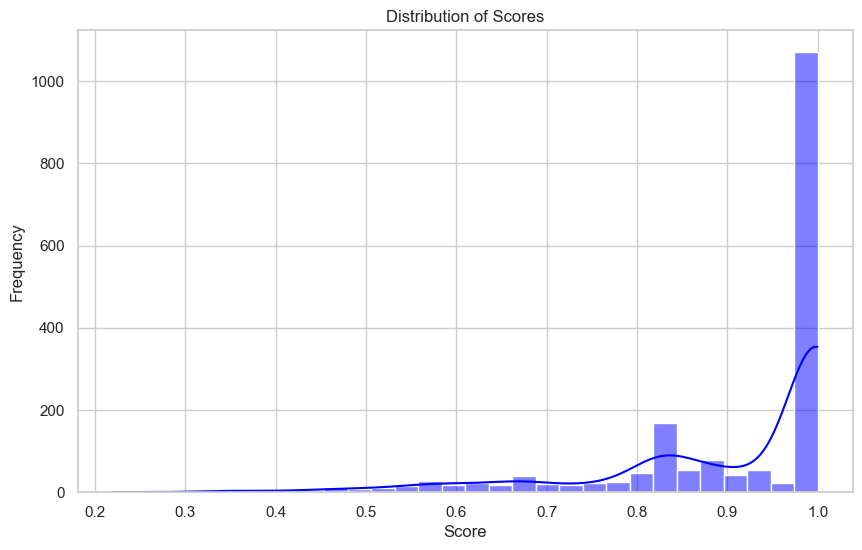

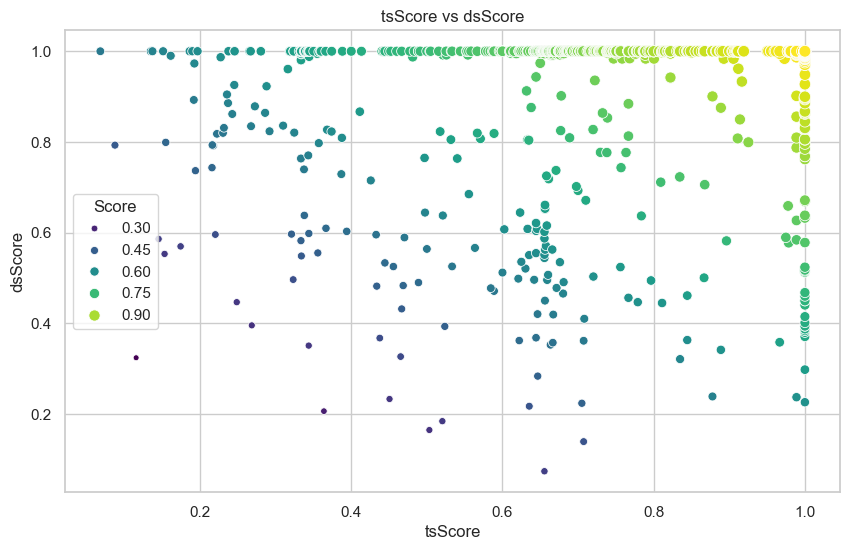

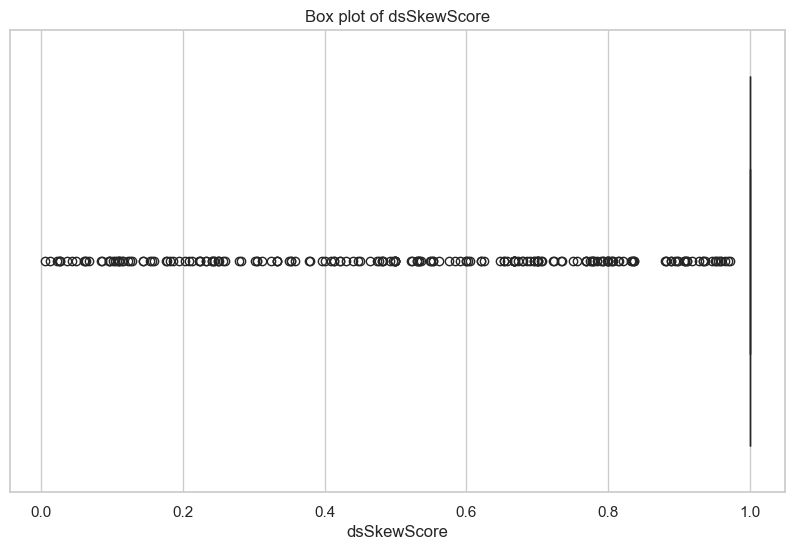

C:\Users\harih\AppData\Local\Temp\ipykernel_4556\3444435422.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=f_http_method, data=http_df, palette='viridis')


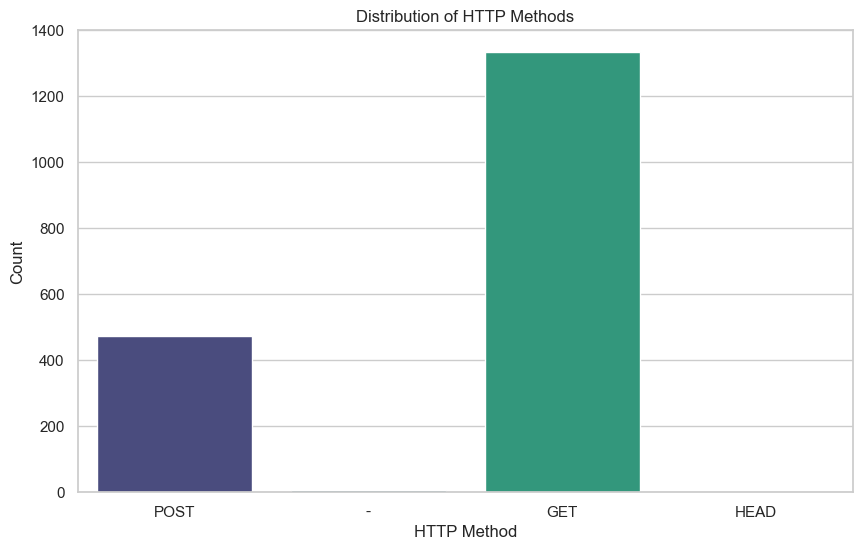

C:\Users\harih\AppData\Local\Temp\ipykernel_4556\3444435422.py:65: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(http_df.corr(), annot=True, cmap='coolwarm')


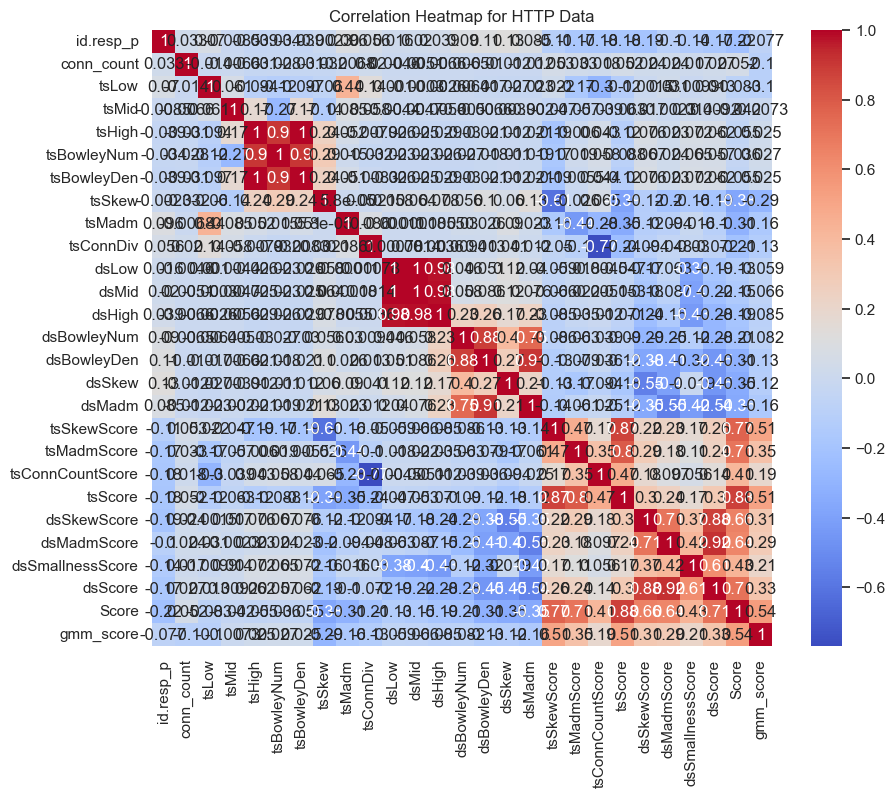

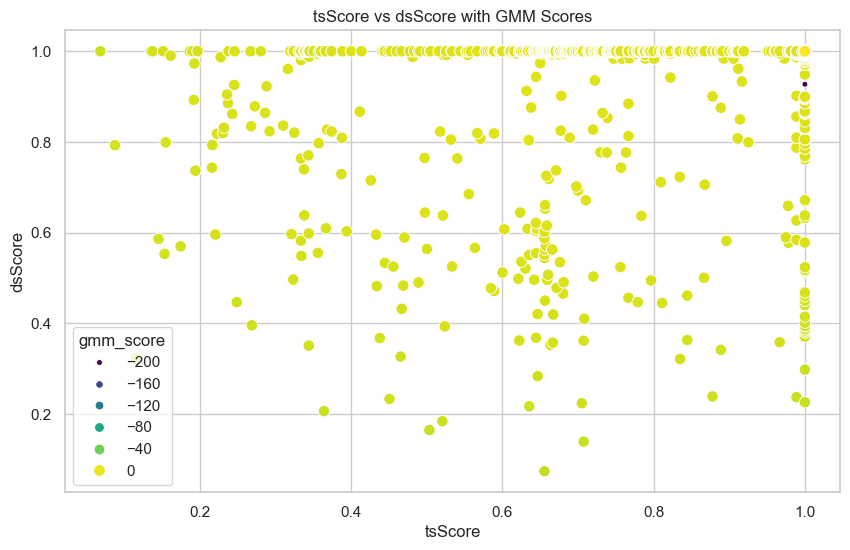

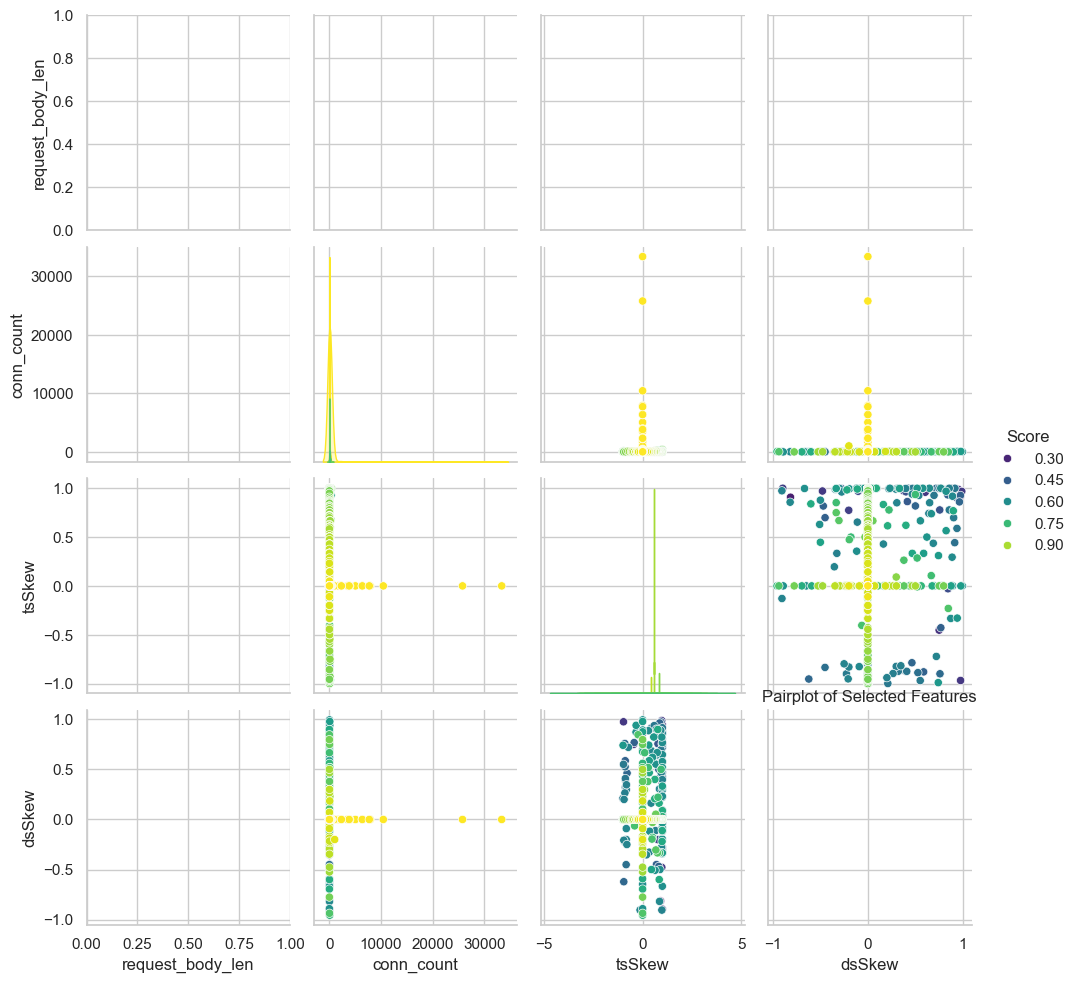

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

G = nx.from_pandas_edgelist(http_df, f_src_ip, f_dst_ip)

# Define different graph layouts
layouts = [nx.spring_layout, nx.random_layout, nx.spiral_layout, nx.circular_layout]
layout_titles = ["Force-directed", "Random", "Spiral", "Circular"]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

# Draw a plot for each layout
for ax, layout, title in zip(axs, layouts, layout_titles):
    pos = layout(G)
    nx.draw_networkx_edges(G, pos, ax=ax, width=0.5, style="solid", edge_color="blue", alpha=0.5, arrows=True, arrowsize=15, arrowstyle="-|>")
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color="black", node_shape="D")
    nx.draw_networkx_labels(G, pos, ax=ax, font_color="red", font_size=8)
    ax.set_title(title)

# Adjust layout
plt.tight_layout()
plt.show()


# Set the style for Seaborn plots
sns.set(style="whitegrid")

# Visualization 1: Distribution of Scores
plt.figure(figsize=(10, 6))
sns.histplot(http_df['Score'], bins=30, kde=True, color='blue')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: Scatter plot of tsScore vs dsScore
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsScore', y='dsScore', data=http_df, hue='Score', size='Score', palette='viridis', legend='auto')
plt.title('tsScore vs dsScore')
plt.xlabel('tsScore')
plt.ylabel('dsScore')
plt.show()

# Visualization 3: Box plot of dsSkewScore
plt.figure(figsize=(10, 6))
sns.boxplot(x='dsSkewScore', data=http_df, color='green')
plt.title('Box plot of dsSkewScore')
plt.xlabel('dsSkewScore')
plt.show()

# Bar Plot for HTTP Methods
plt.figure(figsize=(10, 6))
sns.countplot(x=f_http_method, data=http_df, palette='viridis')
plt.title('Distribution of HTTP Methods')
plt.xlabel('HTTP Method')
plt.ylabel('Count')
plt.show()

# Heatmap for Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(http_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for HTTP Data')
plt.show()

# Convert columns to numeric
http_df['request_body_len'] = pd.to_numeric(http_df['request_body_len'], errors='coerce')
http_df['conn_count'] = pd.to_numeric(http_df['conn_count'], errors='coerce')
http_df['tsSkew'] = pd.to_numeric(http_df['tsSkew'], errors='coerce')
http_df['dsSkew'] = pd.to_numeric(http_df['dsSkew'], errors='coerce')

# Scatter plot of tsScore vs dsScore with GMM scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsScore', y='dsScore', data=http_df, hue='gmm_score', size='gmm_score', palette='viridis', legend='auto')
plt.title('tsScore vs dsScore with GMM Scores')
plt.xlabel('tsScore')
plt.ylabel('dsScore')
plt.show()


# Pairplot for Multiple Features
sns.pairplot(http_df, vars=['request_body_len', 'conn_count', 'tsSkew', 'dsSkew'], hue='Score', palette='viridis')
plt.title('Pairplot of Selected Features')
plt.show()

Linear Regression - Residual Analysis

Coefficients: [0.5 0.5 0. ]
Intercept: 1.9984014443252818e-15
count    1.816000e+03
mean     2.364420e-17
std      9.429326e-16
min     -4.662937e-15
25%     -2.220446e-16
50%     -2.220446e-16
75%      4.440892e-16
max      3.330669e-15
Name: residuals, dtype: float64


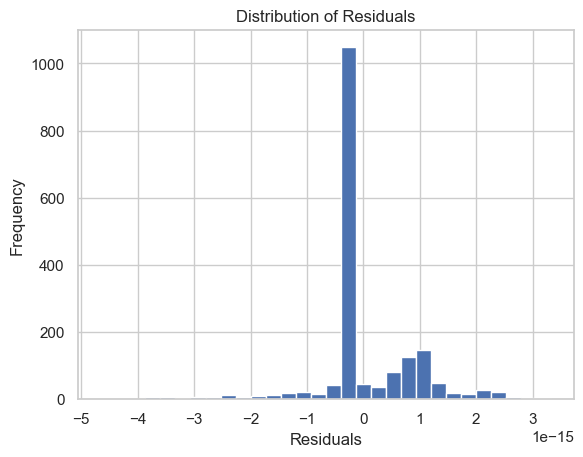

In [11]:
from sklearn.linear_model import LinearRegression

# Select features for regression
features_for_regression = ['tsScore', 'dsScore', 'conn_count']

# Define independent variables (X) and dependent variable (y)
X = http_df[features_for_regression]
y = http_df['Score']

# Initialize Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Predict the scores
http_df['predicted_score'] = model.predict(X)

# Calculate residuals
http_df['residuals'] = y - http_df['predicted_score']


# Print coefficients
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

# Visualize residuals distribution
print(http_df['residuals'].describe())
plt.hist(http_df['residuals'], bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



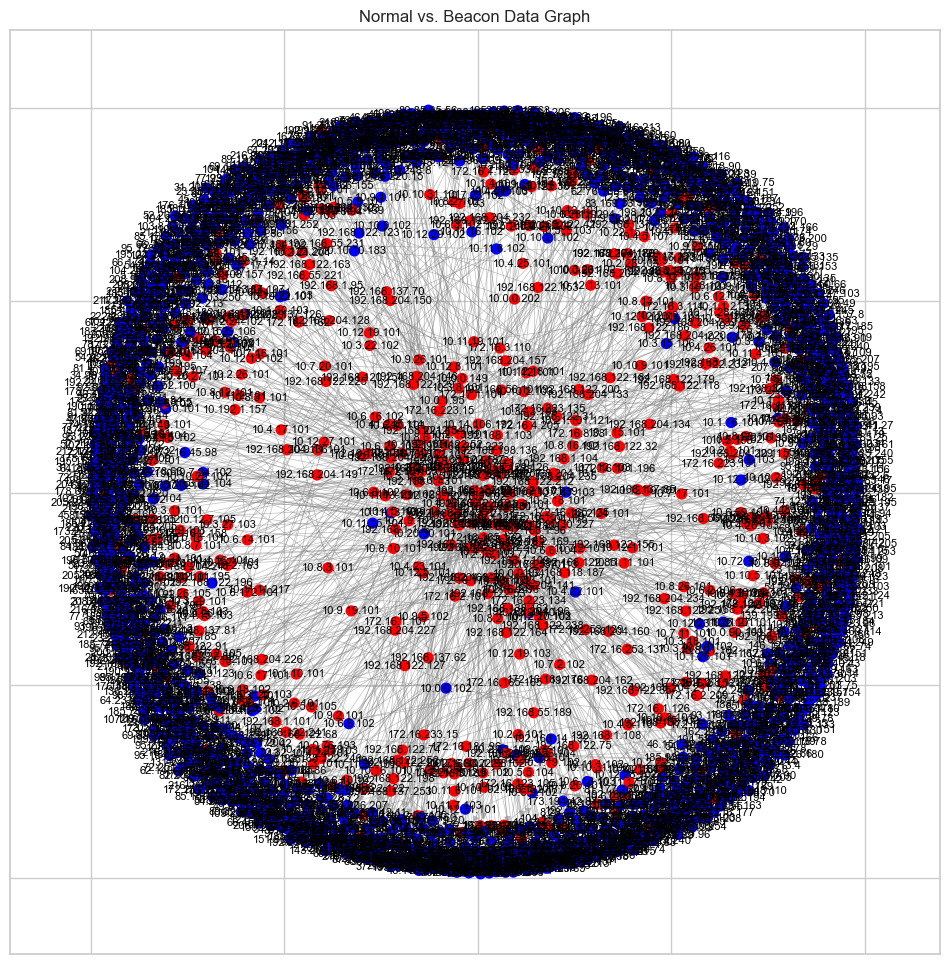

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns


normal_data = http_df[http_df['Score'] <= 0.80]  
beacon_data = http_df[http_df['Score'] > 0.80] 
# Create a directed graph
G = nx.DiGraph()

# Add nodes for normal data
for _, row in normal_data.iterrows():
    G.add_node(row[f_src_ip], color='blue')  

# Add nodes for beacon data
for _, row in beacon_data.iterrows():
    G.add_node(row[f_src_ip], color='red')  
# Add edges based on connections
for _, row in http_df.iterrows():
    G.add_edge(row[f_src_ip], row[f_dst_ip])

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  
node_colors = []
for node in G.nodes(data=True):
    if 'color' in node[1]:
        node_colors.append(node[1]['color'])
    else:
        node_colors.append('blue') 
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=0.5, style="solid", edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G, pos, font_color="black", font_size=8)
plt.title('Normal vs. Beacon Data Graph')
plt.show()

In [29]:
\
# Create a DataFrame with gathered data
gathered_data = {
    'Source IP': http_df[f_src_ip],
    'Destination IP': http_df[f_dst_ip],
    'tsScore': http_df['tsScore'],
    'dsScore': http_df['dsScore'],
    'Connection Count': http_df['conn_count'],
    'Predicted Score': http_df['predicted_score'],
    'Residuals': http_df['residuals']
}

# Convert the dictionary to a DataFrame
gathered_df = pd.DataFrame(gathered_data)

# Define a function to determine if a record is malicious
def is_malicious(row):
    if row['tsScore'] > 0.80 or row['dsScore'] > 0.80:
        return 'Yes'
    else:
        return 'No'

# Apply the function to create a new column 'Malicious'
gathered_df['Malicious'] = gathered_df.apply(is_malicious, axis=1)



# Convert the DataFrame to a string
gathered_df_str = gathered_df.to_string()

# Print the string
print(gathered_df_str)

# Export the DataFrame to a CSV file
gathered_df.to_csv('gathered_data.csv', index=False)

            Source IP   Destination IP   tsScore   dsScore  Connection Count  Predicted Score     Residuals Malicious
0        10.11.15.101    178.63.78.150  0.115635  0.323978                33         0.219807 -6.383782e-16        No
1          10.9.3.101     62.210.90.75  0.363966  0.206200                21         0.285083 -2.275957e-15        No
2        10.11.11.101   51.254.218.210  0.268570  0.395408                45         0.331989 -8.881784e-16        No
3         10.7.17.103    104.236.52.89  0.503407  0.164557                27         0.333982 -3.053113e-15        No
4         10.1.15.101   37.187.195.209  0.450719  0.232996                30         0.341858 -2.442491e-15        No
5         10.6.18.103     84.38.182.41  0.343860  0.350745                63         0.347302 -1.387779e-15        No
6        10.12.20.101     46.101.7.140  0.248679  0.446555                21         0.347617 -4.996004e-16        No
7         10.1.15.101    200.75.39.254  0.520573  0.1840